In [36]:
# !pip install --quiet mediapy
# !pip install --quiet robosuite==1.4
# !pip install --quiet tqdm
# !pip install --quiet ipywidgets
# !pip install --quiet bitsandbytes
# !pip install --quiet accelerate
# !conda install -c conda-forge ffmpeg -y

In [37]:
from robot_utils_w import (
    DATE_TIME,
    get_action,
    get_model,
    invert_gripper_action,
    normalize_gripper_action,
    set_seed_everywhere,
)
from openvla_utils_w import get_processor

""" 
# in openvla_utils.py 
# Need to be commented

from prismatic.extern.hf.configuration_prismatic import OpenVLAConfig
from prismatic.extern.hf.modeling_prismatic import OpenVLAForActionPrediction
from prismatic.extern.hf.processing_prismatic import PrismaticImageProcessor, PrismaticProcessor
...
    # Register OpenVLA model to HF Auto Classes (not needed if the model is on HF Hub)
    AutoConfig.register("openvla", OpenVLAConfig)
    AutoImageProcessor.register(OpenVLAConfig, PrismaticImageProcessor)
    AutoProcessor.register(OpenVLAConfig, PrismaticProcessor)
    AutoModelForVision2Seq.register(OpenVLAConfig, OpenVLAForActionPrediction)

from experiments.robot.robot_utils import (
    DATE_TIME,
    get_action,
    get_model,
    invert_gripper_action,
    normalize_gripper_action,
    set_seed_everywhere,
)
from experiments.robot.openvla_utils import get_processor
"""

from experiments.robot.libero.libero_utils import (
    get_libero_image,
    quat2axisangle,
)

In [38]:
from typing import Optional, Union
from pathlib import Path
import os 
import mediapy
import tqdm
import numpy as np
import cv2

In [39]:
class GenerateConfig:
    # fmt: off

    #################################################################################################################
    # Model-specific parameters
    #################################################################################################################
    model_family: str = "openvla"                    # Model family
    pretrained_checkpoint: Union[str, Path] = ""     # Pretrained checkpoint path
    load_in_8bit: bool = False                       # (For OpenVLA only) Load with 8-bit quantization
    load_in_4bit: bool = False                       # (For OpenVLA only) Load with 4-bit quantization

    center_crop: bool = True                         # Center crop? (if trained w/ random crop image aug)

    #################################################################################################################
    # LIBERO environment-specific parameters
    #################################################################################################################
    task_suite_name: str = "libero_spatial"          # Task suite. Options: libero_spatial, libero_object, libero_goal, libero_10, libero_90
    num_steps_wait: int = 10                         # Number of steps to wait for objects to stabilize in sim
    num_trials_per_task: int = 50                    # Number of rollouts per task

    #################################################################################################################
    # Utils
    #################################################################################################################
    run_id_note: Optional[str] = None                # Extra note to add in run ID for logging
    local_log_dir: str = "./experiments/logs"        # Local directory for eval logs

    use_wandb: bool = False                          # Whether to also log results in Weights & Biases
    wandb_project: str = "YOUR_WANDB_PROJECT"        # Name of W&B project to log to (use default!)
    wandb_entity: str = "YOUR_WANDB_ENTITY"          # Name of entity to log under

    seed: int = 0                                    # Random Seed (for reproducibility)

    # fmt: on

In [40]:
cfg = GenerateConfig()

In [41]:
# ["libero_spatial", "libero_object", "libero_goal", "libero_10"]
cfg.task_suite_name = "libero_10" # can also choose libero_spatial, libero_object, etc.
cfg.pretrained_checkpoint = f"openvla/openvla-7b-finetuned-libero-10"
cfg.load_in_4bit = False
resize_size = 512

In [42]:
# [OpenVLA] Set action un-normalization key
cfg.unnorm_key = cfg.task_suite_name

In [43]:
# Set random seed
set_seed_everywhere(cfg.seed)

In [44]:
model = get_model(cfg)

[*] Instantiating Pretrained VLA model
[*] Loading in BF16 with Flash-Attention Enabled


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You can ignore this if you are loading the base VLA (i.e. not fine-tuned) checkpoint.Otherwise, you may run into errors when trying to call `predict_action()` due to an absent `unnorm_key`.
Loaded model: <class 'transformers_modules.openvla.openvla-7b.31f090d05236101ebfc381b61c674dd4746d4ce0.modeling_prismatic.OpenVLAForActionPrediction'>


In [45]:
# [OpenVLA] Check that the model contains the action un-normalization key
if cfg.model_family == "openvla":
    # In some cases, the key must be manually modified (e.g. after training on a modified version of the dataset
    # with the suffix "_no_noops" in the dataset name)
    if cfg.unnorm_key not in model.norm_stats and f"{cfg.unnorm_key}_no_noops" in model.norm_stats:
        cfg.unnorm_key = f"{cfg.unnorm_key}_no_noops"

In [46]:
cfg.unnorm_key

'libero_10'

In [47]:
# [OpenVLA] Get Hugging Face processor
processor = None
if cfg.model_family == "openvla":
    processor = get_processor(cfg)

In [48]:
from libero.libero import benchmark
from libero.libero.envs import OffScreenRenderEnv
from libero.libero import get_libero_path

In [49]:
def get_libero_env(task, resolution=256):
    """Initializes and returns the LIBERO environment, along with the task description."""
    task_description = task.language
    task_bddl_file = os.path.join(get_libero_path("bddl_files"), task.problem_folder, task.bddl_file)
    env_args = {"bddl_file_name": task_bddl_file, "camera_heights": resolution, "camera_widths": resolution}
    env = OffScreenRenderEnv(**env_args)
    env.seed(0)  # IMPORTANT: seed seems to affect object positions even when using fixed initial state
    return env, task_description

In [50]:
# Initialize LIBERO task suite
benchmark_dict = benchmark.get_benchmark_dict()
task_suite = benchmark_dict[cfg.task_suite_name]()
num_tasks_in_suite = task_suite.n_tasks
print(f"Task suite: {cfg.task_suite_name}")

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task suite: libero_10


In [51]:
task_id = 6

In [52]:
# Get task
task = task_suite.get_task(task_id)

# Get default LIBERO initial states
initial_states = task_suite.get_task_init_states(task_id)

# Initialize LIBERO environment and task description
env, task_description = get_libero_env(task, resolution=256)

print('task_description:')
print(task_description)


[Warning]: datasets path c:\users\stshin\documents\github\kime-vla-tutorial\libero\libero\libero\../datasets does not exist!
[Warning]: datasets path c:\users\stshin\documents\github\kime-vla-tutorial\libero\libero\libero\../datasets does not exist!
task_description:
put the white mug on the plate and put the chocolate pudding to the right of the plate


In [53]:
import imageio

def save_rollout_video(rollout_images, idx):
    """Saves an MP4 replay of an episode."""
    mp4_path = f"./demo_task_{idx}.mp4"
    video_writer = imageio.get_writer(mp4_path, fps=30)
    for img in rollout_images:
        video_writer.append_data(img)
    video_writer.close()
    print(f"Saved rollout MP4 at path {mp4_path}")
    return mp4_path

In [54]:
from tqdm.notebook import tqdm

def test(task_successes, episode_idx, instruction):

    # Reset environment
    env.reset()

    # Set initial states
    obs = env.set_init_state(initial_states[episode_idx])

    # Setup
    t = 0
    replay_images = []
    if cfg.task_suite_name == "libero_spatial":
        max_steps = 400*2  # longest training demo has 193 steps
    elif cfg.task_suite_name == "libero_object":
        max_steps = 400*2  # longest training demo has 254 steps
    elif cfg.task_suite_name == "libero_goal":
        max_steps = 400*2  # longest training demo has 270 steps
    elif cfg.task_suite_name == "libero_10":
        max_steps = 520*2  # longest training demo has 505 steps
    elif cfg.task_suite_name == "libero_90":
        max_steps = 400*2  # longest training demo has 373 steps

    print(f"Starting task : {task}...")

    sim_steps = list(range(max_steps + cfg.num_steps_wait))
    for t in tqdm(sim_steps, desc="처리 중"):
        try:
            # IMPORTANT: Do nothing for the first few timesteps because the simulator drops objects
            # and we need to wait for them to fall
            if t < cfg.num_steps_wait:
                get_libero_dummy_action = [0, 0, 0, 0, 0, 0, -1]
                obs, reward, done, info = env.step(get_libero_dummy_action)
                continue

            # Get preprocessed image
            img = get_libero_image(obs, resize_size)

            # Save preprocessed image for replay video
            replay_images.append(img)            
            # cv2.imshow("Real-time View", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Prepare observations dict
            # Note: OpenVLA does not take proprio state as input
            observation = {
                "full_image": img,
                "state": np.concatenate(
                    (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
                ),
            }

            # Query model to get action
            action = get_action(
                cfg,
                model,
                observation,
                instruction,
                processor=processor,
            )

            # Normalize gripper action [0,1] -> [-1,+1] because the environment expects the latter
            action = normalize_gripper_action(action, binarize=True)

            # [OpenVLA] The dataloader flips the sign of the gripper action to align with other datasets
            # (0 = close, 1 = open), so flip it back (-1 = open, +1 = close) before executing the action
            if cfg.model_family == "openvla":
                action = invert_gripper_action(action)

            # Execute action in environment
            obs, reward, done, info = env.step(action.tolist())
            if done:
                task_successes += 1
                print('Success', task_successes)
                break

        except Exception as e:
            print(f"Caught exception: {e}")
            break
    
    return replay_images


In [55]:
print(f"\nTask: {task_description}")

task_successes = 0
episode_idx = 0
instruction = task_description

replay_images = test(task_successes, episode_idx, instruction)


Task: put the white mug on the plate and put the chocolate pudding to the right of the plate
Starting task : Task(name='LIVING_ROOM_SCENE6_put_the_white_mug_on_the_plate_and_put_the_chocolate_pudding_to_the_right_of_the_plate', language='put the white mug on the plate and put the chocolate pudding to the right of the plate', problem='Libero', problem_folder='libero_10', bddl_file='LIVING_ROOM_SCENE6_put_the_white_mug_on_the_plate_and_put_the_chocolate_pudding_to_the_right_of_the_plate.bddl', init_states_file='LIVING_ROOM_SCENE6_put_the_white_mug_on_the_plate_and_put_the_chocolate_pudding_to_the_right_of_the_plate.pruned_init')...


처리 중:   0%|          | 0/1050 [00:00<?, ?it/s]

Caught exception: name 'tf' is not defined


""

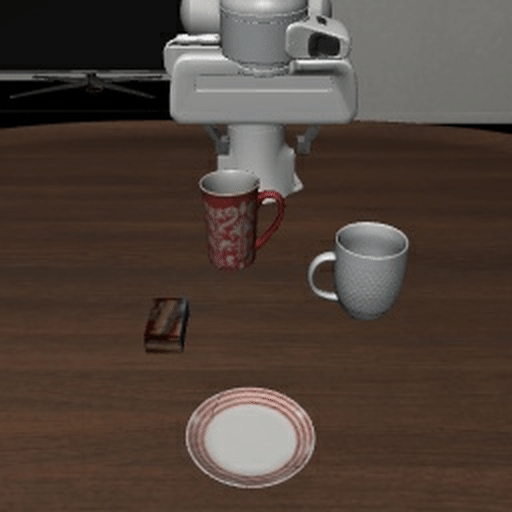

In [56]:
mediapy.show_video(replay_images, fps=15, codec='gif') # needs ffmpeg
# mediapy.show_video(replay_images, fps=15, codec='h264') # for windows

In [57]:
# mediapy.write_image('checkerboard.png', replay_images[0])
mediapy.write_video('checkerboard.gif', replay_images, fps=15, codec='gif')

In [58]:
# Save a replay video of the episode
save_rollout_video(replay_images, episode_idx)

Saved rollout MP4 at path ./demo_task_0.mp4


'./demo_task_0.mp4'

## Addtional Practices

In [59]:

# task_successes = 0
# episode_idx = 0
# instruction = "put the chocolate pudding on the plate"

# replay_images = test(task_successes, episode_idx, instruction)

In [60]:
# mediapy.show_video(replay_images, fps=15, codec='gif')

In [61]:

# task_successes = 0
# episode_idx = 0
# instruction = "put the chocolate pudding on the white mug"

# replay_images = test(task_successes, episode_idx, instruction)


In [62]:
# mediapy.show_video(replay_images, fps=15, codec='gif')